# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger','stopwords'])

from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
# check table names in the database
print(engine.table_names())
# read table from database
df = pd.read_sql_table('DisasterResponse', engine)
# close the connection to the database
conn = engine.raw_connection()
conn.close()

['DisasterResponse', 'Message']


In [4]:
df.head(2)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [5]:
X = df['message']
Y = df.drop(['id', 'message','original', 'genre'], axis = 1)

In [6]:
# Check how many messages contain web links
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
X.str.contains(url_regex).sum()

669

In [7]:
# 'related' category has value 2, but no larger than 2
print('Counts of Y=2: {}; counts of Y>2: {}'.format(Y[Y==2].count().sum(), Y[Y>2].count().sum()) )
Y[Y==2].count()

Counts of Y=2: 188; counts of Y>2: 0


related                   188
request                     0
offer                       0
aid_related                 0
medical_help                0
medical_products            0
search_and_rescue           0
security                    0
military                    0
child_alone                 0
water                       0
food                        0
shelter                     0
clothing                    0
money                       0
missing_people              0
refugees                    0
death                       0
other_aid                   0
infrastructure_related      0
transport                   0
buildings                   0
electricity                 0
tools                       0
hospitals                   0
shops                       0
aid_centers                 0
other_infrastructure        0
weather_related             0
floods                      0
storm                       0
fire                        0
earthquake                  0
cold      

Since there are only 188 "2" in the "related" category.
Replace all "2" with "1" to simplify the features

In [8]:
Y[Y>=2]=1
print('Counts of Y>=2: {}'.format(Y[Y>=2].count().sum()))

Counts of Y>=2: 0


In [9]:
# Check the "1" count in each category
Y[Y>0].count()

related                   20094
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire    

Since "child_alone" category has only "0", it should be dropped off

In [10]:
Y.drop(['child_alone'], axis = 1, inplace=True)

Total messages: 26216


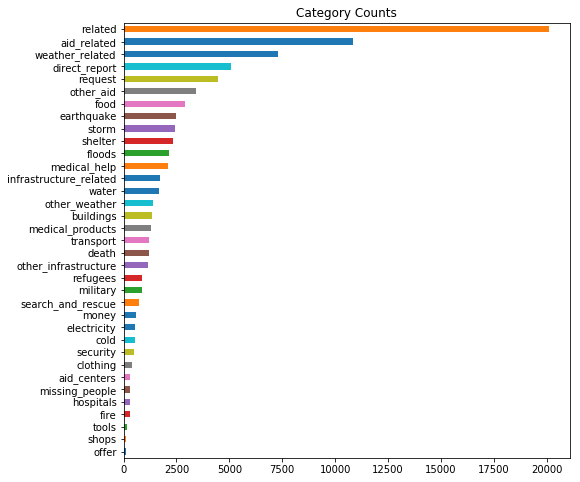

In [11]:
# Check count in each category
print('Total messages: {}'.format(Y.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
Y[Y>0].sum().sort_values().plot.barh(ax=ax,title='Category Counts',fontsize=10);

### 2. Write a tokenization function to process your text data

In [12]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = [ w for w in word_tokenize(text) if w not in nltk.corpus.stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [13]:
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [20]:
vocabulary=pd.DataFrame.from_dict(vect.vocabulary_, orient='index')
vocabulary.columns=['count']
vocabulary_first20=vocabulary['count'].iloc[0:20]

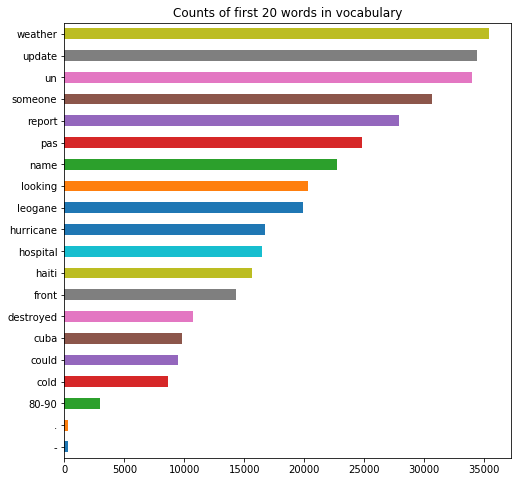

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
vocabulary_first20.sort_values().plot.barh(ax=ax,title='Counts of first 20 words in vocabulary',fontsize=10);

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [22]:
pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier()))
                ]) 

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.3, random_state=4)

# train classifier
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [24]:
# predict on test data
y_pred=pipeline.predict(X_test)

In [25]:
def display_results_0(y_test, y_pred):
    Category_name=y_test.columns.values
    
    # Accumulate the test score for each category
    score=[]
    for i in range(y_pred.shape[1]):
        score.append(precision_recall_fscore_support(y_test.iloc[:,i], y_pred[:,i], average='macro')[0:3])
        # Print out score of first category
        print('Category: {} \n'.format(Category_name[i]))
        print(classification_report(y_test.iloc[:,i], y_pred[:,i]))
            
    # Calculate weighted score for each category and sum them up as and average score
    weights=(Y[Y>0].count())/(Y[Y>0].count().sum())
    score_weight=[]
    for i in range(len(score)):
        score_weight.append(pd.DataFrame(score).iloc[i,:].apply(lambda x: x*weights[i]).values)
    score_Avg=sum(score_weight)
    
    # print out average score    
    print('Model Average Score [precision, recall, f1-score]={}'.format(score_Avg))

In [26]:
display_results_0(y_test, y_pred)

Category: related 

             precision    recall  f1-score   support

          0       0.63      0.39      0.48      1874
          1       0.83      0.93      0.88      5991

avg / total       0.78      0.80      0.78      7865

Category: request 

             precision    recall  f1-score   support

          0       0.89      0.98      0.93      6511
          1       0.80      0.42      0.55      1354

avg / total       0.87      0.88      0.87      7865

Category: offer 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7827
          1       0.00      0.00      0.00        38

avg / total       0.99      1.00      0.99      7865

Category: aid_related 

             precision    recall  f1-score   support

          0       0.75      0.85      0.80      4634
          1       0.73      0.59      0.65      3231

avg / total       0.74      0.74      0.74      7865

Category: medical_help 

             precision    recall 

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model Average Score [precision, recall, f1-score]=[ 0.7818185   0.6517321   0.67482662]


### 6. Improve your model
Use grid search to find better parameters. 

In [28]:
pipeline2 = Pipeline([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

In [29]:
parameters = {
    'clf__estimator__n_estimators': [20, 50]
}

cv = GridSearchCV(pipeline2, param_grid=parameters,scoring='f1_macro',cv=3)

In [30]:
cv.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__n_estimators': [20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [31]:
y_pred = cv.predict(X_test)

In [166]:
def display_results(y_test, y_pred, cv):
    Category_name=y_test.columns.values
    
    # Accumulate the test score for each category
    score=[]
    for i in range(y_pred.shape[1]):
        score.append(precision_recall_fscore_support(y_test.iloc[:,i], y_pred[:,i], average='macro')[0:3])
        # Print out score of first category
        if i==0:
            print('Category: {} \n'.format(Category_name[i]))
            print(classification_report(y_test.iloc[:,i], y_pred[:,i]))
            
    # Calculate weighted score for each category and sum them up as and average score
    weights=(Y[Y>0].count())/(Y[Y>0].count().sum())
    score_weight=[]
    for i in range(len(score)):
        score_weight.append(pd.DataFrame(score).iloc[i,:].apply(lambda x: x*weights[i]).values)
    score_Avg=sum(score_weight)
    
    # Print out model if from GridSearch
    print("\nBest Parameters:", cv.best_params_)

    # print out average score    
    print('Model Average Score [precision, recall, f1-score]={}'.format(score_Avg))

In [34]:
display_results(y_test, y_pred,cv) 

Category: related 

             precision    recall  f1-score   support

          0       0.71      0.34      0.46      1874
          1       0.82      0.96      0.88      5991

avg / total       0.80      0.81      0.78      7865



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best Parameters: {'clf__estimator__n_estimators': 50}
Model Average Score [precision, recall, f1-score]=[ 0.80743172  0.66620287  0.68978788]


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [108]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return 1
        return 0

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [36]:
def load_data():
    # load data from database
    engine = create_engine('sqlite:///DisasterResponse.db')
    # read table from database
    df = pd.read_sql_table('DisasterResponse', engine)
    # close the connection to the database
    conn = engine.raw_connection()
    conn.close()
    X = df['message']
    Y = df.drop(['id', 'message','original', 'genre','child_alone'], axis = 1)
    Y[Y>=2]=1
    
    return X, Y


In [6]:
def build_model():
    Pipeline([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

        ('clf', MultiOutputClassifier(LinearSVC()))
    ])
    
    parameters = {
    'clf__estimator__C': [10, 50.0]
    }

    # create grid search object
    cv = GridSearchCV(pipeline,param_grid=parameters,scoring='f1_macro',cv=3)
    
    return cv

#### Try if my pipeline is still working after adding "StartingVerbExtractor" feature
I found that I have to modify StartingVerbExtractor() by making sure sentence has more than 1 word

In [39]:
load_data();

In [ ]:
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [42]:
X_vectorized.shape

(26216, 36561)

In [45]:
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X_vectorized)
tfidf.shape

(26216, 36561)

In [89]:
transformer_tag=StartingVerbExtractor()
for i in range(X.shape[0]):
    try:
        X_tag[i]=(transformer_tag.transform(X.iloc[i]))
    except:
        print(i)
        print(X.iloc[i])

10487
Feeling for the victims of the Haiti earthquake. And Jurasse. o


In [96]:
sentence_list = nltk.sent_tokenize(X.iloc[10487])
sentence_list

['Feeling for the victims of the Haiti earthquake.', 'And Jurasse.', 'o']

In [109]:
pos_tags = nltk.pos_tag(tokenize(sentence_list[2]))
pos_tags

[]

In [114]:
class StartingVerbExtractor_v2(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))   # part-of-speech tagging
            if pos_tags != []:
                first_word, first_tag = pos_tags[0]
                if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                    return 1
        return 0

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [115]:
transformer_tag=StartingVerbExtractor_v2()
X_tag=transformer_tag.transform(X)
        
X_tag.shape

(26216, 1)

#### Build pipeline3 with parallel "StartingVerbExtractor" feature and "LinearSVC" estimator

In [119]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [121]:
pipeline3 = Pipeline([
        ('features', FeatureUnion([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor_v2())
        ])),
    
        ('clf', MultiOutputClassifier(LinearSVC()))
    ])

In [122]:
# train classifier
pipeline3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...ti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
           n_jobs=1))])

In [124]:
# Predict for test data
y_pred = pipeline3.predict(X_test)    
display_results(y_test, y_pred, model)

Category: related 

             precision    recall  f1-score   support

          0       0.66      0.51      0.57      1874
          1       0.86      0.92      0.89      5991

avg / total       0.81      0.82      0.81      7865



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model Average Score [precision, recall, f1-score]=[ 0.78819406  0.71821647  0.74026735]


#### Now, build model_v2 with pipeline3 (parallel "StartingVerbExtractor" feature and "LinearSVC" estimator) and GridSearchCV

In [150]:
def build_model_v2():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor_v2())
        ])),
    
        ('clf', MultiOutputClassifier(LinearSVC()))
    ])
    
    parameters = {
    'features__text_pipeline__vect__max_df': (0.5, 1.0),
    'clf__estimator__C': [1.0, 5.0]
    }

    # create grid search object
    cv = GridSearchCV(pipeline,param_grid=parameters,scoring='f1_macro',cv=3)
    
    return cv

In [152]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

    model = build_model_v2()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    display_results(y_test, y_pred, model)
    
main()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

Category: related 

             precision    recall  f1-score   support

          0       0.60      0.53      0.56      1874
          1       0.86      0.89      0.87      5991

avg / total       0.80      0.80      0.80      7865


Best Parameters: {'clf__estimator__C': 5.0, 'features__text_pipeline__vect__max_df': 1.0}
Model Average Score [precision, recall, f1-score]=[ 0.74548294  0.71257719  0.72556921]


### 9. Export your model as a pickle file

In [156]:
filename = 'model.pkl'
pickle.dump(model, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.